In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
from pathlib import Path
from os.path import join
import pandas as pd
import numpy as np
import numpy.ma as ma

from util.files import *
from util.const import *
from util.ddfs import *

In [3]:
# FIPS will be passed in as an argument, one day...
FIPS = '34007'
# STATE ABBR and NATION will be derived from FIPS, one day...
STATEABBR = 'NJ'
NATION = 'US'

# I think it also could make sense to pass in scenario and
# ddf type as arguments. For main results
# we're using 'mid' and 'naccs' but for generating
# our sensitivity analysis results we will need to pass
# in the other scenarios and 'hazus'
# Very well suited for snakemake :) 
SCENARIO = 'Mid'
DDF_TYPE = 'naccs'

# Load and Prepare Data

In [214]:
# Load the ensemble data, along with the optimal & dfe
# elevation results
opt_elev_filename = 'ens_opt_elev_' + DDF_TYPE + '_' + SCENARIO + '.pqt'
dfe_elev_filename = 'ens_dfe_elev_' + DDF_TYPE + '_' + SCENARIO + '.pqt'
ens_filename = 'ensemble_' + SCENARIO + '.pqt'

ens_df = pd.read_parquet(join(FO, ens_filename))
opt_elev_df = pd.read_parquet(join(EXP_DIR_I, FIPS, opt_elev_filename))
dfe_elev_df = pd.read_parquet(join(EXP_DIR_I, FIPS, dfe_elev_filename))

In [215]:
# Merge on fd_id and sow_ind to get eal_avoid, elev_cost, and opt_elev
# into the ensemble
ens_df = ens_df.merge(opt_elev_df,
                      on=['fd_id', 'sow_ind'],
                      suffixes=['','_opt'])
# Merge dfe_elev_df as well, adding suffixes
ens_df = ens_df.merge(dfe_elev_df,
                      on=['fd_id', 'sow_ind'],
                      suffixes=['','_dfe'])

In [216]:
# We also need to load in the links between structures and the
# social vulnerability data for sorting rules
sovi_filepath = join(VULN_DIR_I, 'social', FIPS, 'c_indicators.pqt')
sovi_df = pd.read_parquet(sovi_filepath)

In [217]:
# Download discount rate chains from external source
# The rows correspond to house lifetime, indexed at 0
# The columns correspond to states of the world, indexed at 0
dr_chains = pd.read_csv(join(FE, 'dr_chains.csv'),
                        header=None)

# Following https://www.journals.uchicago.edu/doi/10.1086/718145
# and https://doi.org/10.1162/rest_a_01109, replace values < 0 with 0
# The economic argument is that descriptive discount rates will not
# be less than 0 for long. Bauer and Rudebusch (the latter link)
# have ~ 3 paragraphs addressing the mechanisms behind this
# which I have paraphrased badly here. Some of the intuition is that
# when nominal rates are low and inflation is high, households
# can hold cash and reduce spending, bringing inflation down
# and real rates back up. They offer a more complex, comprehsneive,
# and convincing argument. I have had some conversations about
# scrutinizing this assumption in a future paper. 
dr_chains[dr_chains < 0] = 0

# Need to turn these into discount factors, following
# Maggie's code
# We need the rates as percentages, then we take the cumulative
# sum of these such that the discount factor in year t
# is the sum of all rates leading to that
# Then we take e^- of that value
dr_factors = np.exp(-(dr_chains/100).cumsum())

In [218]:
# Generate house lifetime draws from the weibull distribution
# following https://www.nature.com/articles/s41467-020-19188-9
# Weibull with shape and scale parameters of 2.8 and 73.5
# In numpy, you generate draws from a 1 parameter Weibull
# using the shape parameter, and multiply these draws from
# the scale parameter
# It's likely that house lifetime distributions are different for
# elevated and non-elevated properties exposed to flooding, but
# we don't have this information. While the method can be improved,
# Maggie's paper demonstrates the importance of accounting for
# house lifetime uncertainty in estimating project benefits. In
# particular, when discount rates in the future are low and project
# lifetimes are long, the net benefits will be higher than
# under the standard procedure (moderate discount rate and
# 30 year lifetime). The standard procedure -- which also requires
# that the project BCR > 1 -- will tend to under-prefer
# investment in lower valued structures which need a longer time
# to exceed the BCR > 1 threshold. So again, while future work
# should improve on this, accounting for house lifetime uncertainty
# matters when you're dealing with a BCR > 1 rule, as we are. 
# Since this is about the interaction with the discount rate, and
# we don't have the ability to associate the parameters with
# housing characteristics, I will use the same draws for each house
# and interpret this as uncertainty in the house lifetime parameter
# whose benchmark value is 30. 

rng = np.random.default_rng()
lifetime = rng.weibull(W_SHAPE, N_SOW)*W_SCALE

# Calculate net present benefits

In [219]:
# In each SOW, the optimal elevation value corresponds to a discount 
# rate chain realization over N years, L of which the proeprty will
# still be around for (L draws from the lifetime series)
# One approach to do this relatively quickly is to process everything
# for matrix multiplication. If we can take the eal_avoid series
# and expand it column-wise based on house lifetime draws (i.e.
# repeat the value for the house lifetime draw then turn to 0)
# then we can do matrix multiplication on the dr_chains dataframe
# which we would have to repeat column-wise to match
# the number of structures we have. If memory allows, I think this is 
# faster than doing a groupby and apply. This is also
# embarassingly parallel, so we could do this step in batches on
# our cluster. If I can do it in a single script, I will, because
# that workflow is likely more widely accessible. So, I will first
# try making the big matrices and doing multiplication, then
# I'll use the groupby/apply approach if I have to, and if I need to
# I will move to batch processing
# Because we are dealing with a small number of structures, the 
# first approach with matrix multiplication works great. 


In [220]:
# We need net present values of the following
# benefits from optimal elevation
# benefits from elevation to design flood elevation standards (BFE + 4)
# new - old eal (new under both elevation scenarios)


In [237]:
# Use the lifetime series to create a mask
# Can adapt this code
# https://stackoverflow.com/questions/55190295/
# create-a-2-d-mask-from-a-1-d-numpy-array
# This code is complex, so I want to explain what is happening. You
# can also look at the stackoverflow link which provides helpful
# information. 
# So, let's start from the inside out. The first command 
# is np.less.outer(lifetime, np.arange(100))
# This takes the lifetime array, which is N_SOW in length
# and broadcasts that with outer into a N_SOW*100 shape 2d array
# 100 is the max lifetime we consider since discount rates are
# projected through 2100. We're comparing the values in lifetime
# to the values in the np.arange(100) array, and when the lifetime
# value is less, the element is assigned True. This creates
# a mask of True/False values which we need to match up to
# our 100x2390000 matrix of eal_avoid values. We do this first by
# transposing, then tiling along the columns the same number
# of times as we have structures in our sample. 
lifetime_mask = np.tile(np.less.outer(lifetime, np.arange(100)).T,
                        (1, len(ens_df['fd_id'].unique())))

# avoided losses from optimal elevation matrix
eal_avoid_opt = np.tile(ens_df['eal_avoid'], (100, 1))
# same for dfe
eal_avoid_dfe = np.tile(ens_df['eal_avoid_dfe'], (100, 1))
# Apply the lifetime_mask to eal_avoid
eal_av_life_opt = ma.masked_array(eal_avoid_opt, mask=lifetime_mask, fill_value=0)
# Same for dfe
eal_av_life_dfe = ma.masked_array(eal_avoid_dfe, mask=lifetime_mask, fill_value=0)

# discount rate matrix
dr_matrix = np.tile(dr_factors, (1, len(ens_df['fd_id'].unique())))

# net present value of benefits from matrix multiplication
pv_benefits_opt = (eal_av_life_opt*dr_matrix).sum(axis=0)
pv_benefits_dfe = (eal_av_life_dfe*dr_matrix).sum(axis=0)

# Add back into ens_df
ens_df['pv_opt_elev'] = pv_benefits_opt.data
ens_df['pv_dfe_elev'] = pv_benefits_dfe.data

# Need to also get the present values of the r_eal and r_eal_dfe
# and the DDF_TYPE + _eal. For the first two, we add these
# back to invst_cost to get the pv of the costs which
# we need for calculating net present values of the elevations
# We're repeating the procedure from above
r_eal_opt = np.tile(ens_df['r_eal'], (100, 1))
r_eal_dfe = np.tile(ens_df['r_eal_dfe'], (100, 1))
r_eal_opt_life = ma.masked_array(r_eal_opt, mask=lifetime_mask, fill_value=0)
r_eal_dfe_life = ma.masked_array(r_eal_dfe, mask=lifetime_mask, fill_value=0)
pv_r_eal_opt = (r_eal_opt_life*dr_matrix).sum(axis=0)
pv_r_eal_dfe = (r_eal_dfe_life*dr_matrix).sum(axis=0)
ens_df['pv_r_eal_opt'] = pv_r_eal_opt.data
ens_df['pv_r_eal_dfe'] = pv_r_eal_dfe.data
# We're doing it for "base" eal as well
base_eal = np.tile(ens_df[DDF_TYPE + '_eal'], (100, 1))
base_eal_life = ma.masked_array(base_eal, mask=lifetime_mask, fill_value=0)
pv_base_eal = (base_eal_life*dr_matrix).sum(axis=0)
ens_df['pv_base_eal'] = pv_base_eal.data

# Now add pv of residual eal to the invst_cost for the pv_cost columns
ens_df['pv_cost_opt'] = ens_df['elev_invst'] + ens_df['pv_r_eal_opt']
ens_df['pv_cost_dfe'] = ens_df['elev_invst_dfe'] + ens_df['pv_r_eal_dfe']

In [239]:
# Now get the difference of benefits and costs
ens_df['npv_opt'] = ens_df['pv_opt_elev'] - ens_df['pv_cost_opt']
ens_df['npv_dfe'] = ens_df['pv_dfe_elev'] - ens_df['pv_cost_dfe']
# And the ratio
ens_df['bcr_opt'] = ens_df['pv_opt_elev']/ens_df['pv_cost_opt']
ens_df['bcr_dfe'] = ens_df['pv_dfe_elev']/ens_df['pv_cost_dfe']

Text(0.5, 0, 'BCR From Optimal Flood Elevation Standard')

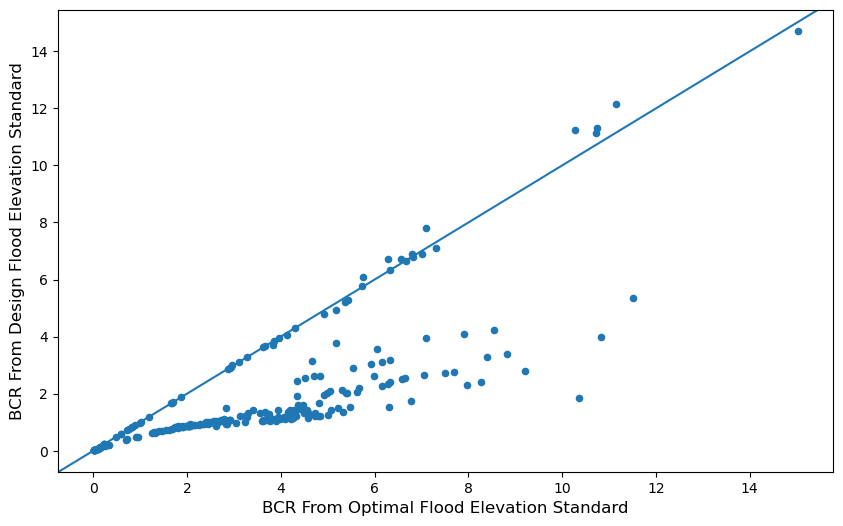

In [245]:
temp = ens_df.groupby('fd_id')['bcr_opt'].mean()
temp2 = ens_df.groupby('fd_id')['bcr_dfe'].mean()
comp = pd.concat([temp, temp2], axis=1)

import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(10, 6))
comp.plot(x='bcr_opt', y='bcr_dfe', ax=ax, kind='scatter')
ax.axline([0, 0], [1, 1])
ax.set_ylabel('BCR From Design Flood Elevation Standard', size=12)
ax.set_xlabel('BCR From Optimal Flood Elevation Standard', size=12)


# Allocate funding

In [ ]:
# Now that we have these values we can start sorting! 
# The sovi_df we loaded has the fd_id which are in different
# tracts
# We still need to calculate the household metrics for sorting
# We will sort until we expend our budget, which goes from 1 mil
# to 36 mil in investment costs in 5 mil increments
# For half the policies, the project BCR must be > 1, for
# the other half, the project BCR can be less than 1
# I don't think this rule will make a big difference in 
# our case study, but we shall see